# Paquetes

In [32]:
# BASIC PACKAGES
# =============================================================================
import cv2
import glob
import numpy as np
import os
import pandas as pd
import pyfeats
import random
import seaborn as sns
import time
from functools import wraps
from glob import glob
from natsort import natsorted
from pandas import DataFrame
from PIL import Image
from tqdm import tqdm
from warnings import simplefilter
from zipfile import ZipFile
from sklearn.model_selection import GroupShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [33]:
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
from sklearn.metrics import recall_score, f1_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import decomposition, linear_model, preprocessing, pipeline

# Funciones

In [169]:
from funciones_romina import *

# Carga de datos

In [4]:
# 1. CONFIGURACIÓN - Modificar según tus datos
ZIP_PATH = r"C:\Users\Usuario\OneDrive\Desktop\PASANTIA_F&A\rooting_data.zip"
CSV_PATH = r"C:\Users\Usuario\OneDrive\Desktop\PASANTIA_F&A\rooting_data\rooting_data.csv"
DATE_COLS = ["datetime"]  # Columnas con fechas, o None si no hay

In [5]:
# Nombres de columnas en tu CSV
RGB_COLUMN = "rgb_path"
MASK_COLUMN = "canopy_mask_path"
THERMAL_COLUMN = "thermal_path"
LABEL_COLUMN = "root_scale"
ID_COLUMN = "tray_id"

In [6]:
# 2. DESCOMPRIMIR DATOS
unzip_data(ZIP_PATH)

Archivos extraídos en: ./


In [7]:
# 3. CARGAR CSV CON METADATOS
df_metadata = load_metadata_csv(CSV_PATH, DATE_COLS)

In [8]:
# 4. REPORTE DE VALORES NULOS
nr_df = null_report(df_metadata).sort_values(by='null_values', ascending=False)
print(nr_df)
print("\n")
print(df_metadata)

                            column  null_values  null_percentage
root_scale              root_scale           12          0.42523
plant_id                  plant_id           12          0.42523
datetime                  datetime            0          0.00000
rgb_path                  rgb_path            0          0.00000
thermal_path          thermal_path            0          0.00000
tray_id                    tray_id            0          0.00000
canopy_mask_path  canopy_mask_path            0          0.00000


                       datetime  \
0    2025-05-23 14:56:32.381513   
1    2025-05-23 14:57:01.571230   
2    2025-05-23 15:01:52.215122   
3    2025-05-23 15:02:55.030068   
4    2025-05-23 15:03:04.907727   
...                         ...   
2817 2025-06-06 19:40:01.293863   
2818 2025-06-06 19:40:09.417868   
2819 2025-06-06 19:40:32.599631   
2820 2025-06-06 19:40:48.332466   
2821 2025-06-06 19:40:56.774791   

                                           thermal_path  

In [9]:
# 5. VERIFICAR ETIQUETAS FALTANTES
check_missing_labels(df_metadata, LABEL_COLUMN, ID_COLUMN)

Registros sin etiquetas: 12 de 2822 (0.42523%)


In [10]:
# 6. CARGAR TODAS LAS IMÁGENES
imgs_lst, missing_files = load_all_images(
    df_metadata,
    RGB_COLUMN,
    MASK_COLUMN,
    THERMAL_COLUMN,
    decode_thermal_image
)

CARGANDO IMÁGENES
✓ Cargadas 2822 imágenes RGB
Archivo no encontrado: ./processed_data/2025_05_30/tray_18_2ENR_XDUN2436_1/plant_62_root_scale_3/photo_3_1748621272966100_canopy_mask.jpg
Archivo no encontrado: ./processed_data/2025_06_06/tray_19_2ENR_XDUN2436_8/plant_44_root_scale_2/photo_5_1749232269792327_canopy_mask.jpg
✓ Cargadas 2822 máscaras
⚠ Archivos faltantes: 2
✓ Cargadas 2822 imágenes térmicas
CARGA COMPLETADA - Total: 2822 sets de imágenes


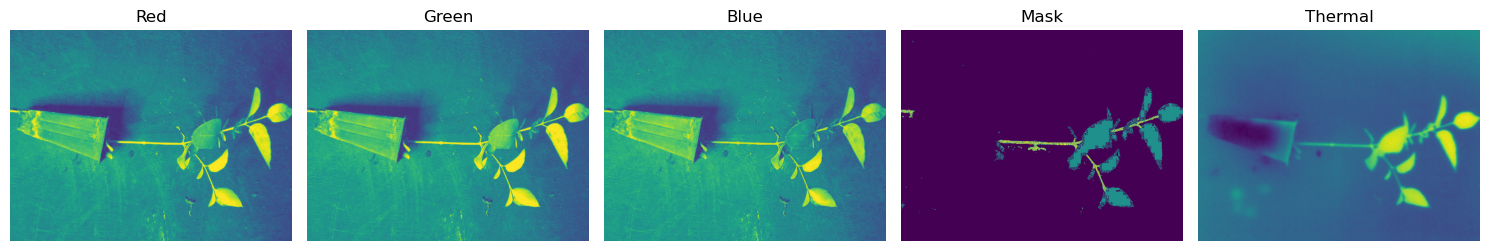

Mostrando imagen #1312


In [12]:
# 7. VISUALIZAR MUESTRA ALEATORIA
plot_sample_images(imgs_lst)

# Extracción de descriptores FOS - OBJ.esp1

Extracción de descriptores a partir de imágenes térmicas y RGB con el fin de caracterizar los ejemplares de interés

In [56]:
# Procesar tus imágenes
df_resultados = generar_dataframe_estructurado(imgs_lst)
df_resultados

Procesando tomas: 100%|██████████| 2822/2822 [00:27<00:00, 103.76it/s]


,Termica_global_hojas_FOS_Mean,Termica_global_hojas_FOS_Variance,Termica_global_hojas_FOS_Median,Termica_global_hojas_FOS_Mode,Termica_global_hojas_FOS_Skewness,Termica_global_hojas_FOS_Kurtosis,Termica_global_hojas_FOS_Energy,Termica_global_hojas_FOS_Entropy,Termica_global_hojas_FOS_MinimalGrayLevel,Termica_global_hojas_FOS_MaximalGrayLevel,...,Termica_global_tallos_FOS_Energy,Termica_global_tallos_FOS_Entropy,Termica_global_tallos_FOS_MinimalGrayLevel,Termica_global_tallos_FOS_MaximalGrayLevel,Termica_global_tallos_FOS_CoefficientOfVariation,Termica_global_tallos_FOS_10Percentile,Termica_global_tallos_FOS_25Percentile,Termica_global_tallos_FOS_75Percentile,Termica_global_tallos_FOS_90Percentile,Termica_global_tallos_FOS_HistogramWidth
index,,,,,,,,,,,,,,,,,,,,,
0,20.42410,1.99881,20.0,22.0,-0.16974,1.87599,0.20935,1.65516,17.0,24.0,...,0.21829,1.61615,17.0,24.0,0.22436,18.0,19.0,21.0,22.0,4.0
1,20.01071,1.63254,20.0,19.0,0.18234,2.25374,0.22634,1.58809,17.0,26.0,...,0.23638,1.57688,17.0,26.0,0.22361,19.0,19.0,21.0,22.0,3.0
2,23.07315,2.66660,23.0,22.0,0.69247,3.22508,0.22133,1.73431,20.0,27.0,...,0.26617,1.55723,20.0,27.0,0.21066,21.0,21.0,23.0,24.0,3.0
3,21.94870,2.36447,22.0,21.0,1.08309,4.12494,0.23695,1.65093,20.0,27.0,...,0.22444,1.63096,20.0,26.0,0.21185,20.0,20.0,22.0,23.0,3.0
4,22.24273,3.75116,21.0,21.0,0.86960,2.46182,0.25088,1.63227,20.0,26.0,...,0.25931,1.58835,20.0,26.0,0.21192,20.0,20.0,22.0,25.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,23.75345,0.92442,24.0,24.0,-0.23341,4.10705,0.33420,1.32645,20.0,27.0,...,0.37865,1.19075,20.0,25.0,0.20812,22.0,23.0,23.0,24.0,2.0
2818,23.42189,1.32657,24.0,24.0,-1.75223,6.06752,0.35250,1.33407,19.0,26.0,...,0.25694,1.60590,19.0,26.0,0.20963,21.0,22.0,24.0,24.0,3.0
2819,23.98215,1.16042,24.0,24.0,-1.32570,4.22827,0.31312,1.35041,20.0,26.0,...,0.30742,1.35628,20.0,26.0,0.20600,22.0,23.0,24.0,24.0,2.0


In [60]:
# Se fusionan usando la columna 'index' de df_resultados con el índice de df_metadata
df_final = pd.merge(
    df_resultados,
    df_metadata[['tray_id', 'plant_id', 'root_scale']],
    left_on='index',      # Usa la COLUMNA 'index' del DataFrame izquierdo
    right_index=True,     # Usa el ÍNDICE del DataFrame derecho (df_metadata)
    how='left'
)

In [61]:
# Ahora df_final tiene todas las características + metadatos
df_final

,Termica_global_hojas_FOS_Mean,Termica_global_hojas_FOS_Variance,Termica_global_hojas_FOS_Median,Termica_global_hojas_FOS_Mode,Termica_global_hojas_FOS_Skewness,Termica_global_hojas_FOS_Kurtosis,Termica_global_hojas_FOS_Energy,Termica_global_hojas_FOS_Entropy,Termica_global_hojas_FOS_MinimalGrayLevel,Termica_global_hojas_FOS_MaximalGrayLevel,...,Termica_global_tallos_FOS_MaximalGrayLevel,Termica_global_tallos_FOS_CoefficientOfVariation,Termica_global_tallos_FOS_10Percentile,Termica_global_tallos_FOS_25Percentile,Termica_global_tallos_FOS_75Percentile,Termica_global_tallos_FOS_90Percentile,Termica_global_tallos_FOS_HistogramWidth,tray_id,plant_id,root_scale
index,,,,,,,,,,,,,,,,,,,,,
0,20.42410,1.99881,20.0,22.0,-0.16974,1.87599,0.20935,1.65516,17.0,24.0,...,24.0,0.22436,18.0,19.0,21.0,22.0,4.0,17_2_XDUN2436min1,NaN,NaN
1,20.01071,1.63254,20.0,19.0,0.18234,2.25374,0.22634,1.58809,17.0,26.0,...,26.0,0.22361,19.0,19.0,21.0,22.0,3.0,17_2_XDUN2436min1,NaN,NaN
2,23.07315,2.66660,23.0,22.0,0.69247,3.22508,0.22133,1.73431,20.0,27.0,...,27.0,0.21066,21.0,21.0,23.0,24.0,3.0,17_2_XDUN2436min1,1.0,0.0
3,21.94870,2.36447,22.0,21.0,1.08309,4.12494,0.23695,1.65093,20.0,27.0,...,26.0,0.21185,20.0,20.0,22.0,23.0,3.0,17_2_XDUN2436min1,2.0,0.0
4,22.24273,3.75116,21.0,21.0,0.86960,2.46182,0.25088,1.63227,20.0,26.0,...,26.0,0.21192,20.0,20.0,22.0,25.0,5.0,17_2_XDUN2436min1,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,23.75345,0.92442,24.0,24.0,-0.23341,4.10705,0.33420,1.32645,20.0,27.0,...,25.0,0.20812,22.0,23.0,23.0,24.0,2.0,19_2ENR_XDUN2436_10,92.0,2.0
2818,23.42189,1.32657,24.0,24.0,-1.75223,6.06752,0.35250,1.33407,19.0,26.0,...,26.0,0.20963,21.0,22.0,24.0,24.0,3.0,19_2ENR_XDUN2436_10,93.0,2.0
2819,23.98215,1.16042,24.0,24.0,-1.32570,4.22827,0.31312,1.35041,20.0,26.0,...,26.0,0.20600,22.0,23.0,24.0,24.0,2.0,19_2ENR_XDUN2436_10,94.0,3.0


# Implementación de métricas de similitud - OBJ.esp2

Implementación de métricas de similitud a partir de atributos obtenidos de imágenes térmicas y RGB de plantas con el fin de evaluar la relación entre ambas fuentes de información.

Preparación de datos

In [62]:
# Crear copia del dataset procesado
data = df_final.copy()
data = data.reset_index(drop=True)
data = data.dropna()

In [63]:
data

,Termica_global_hojas_FOS_Mean,Termica_global_hojas_FOS_Variance,Termica_global_hojas_FOS_Median,Termica_global_hojas_FOS_Mode,Termica_global_hojas_FOS_Skewness,Termica_global_hojas_FOS_Kurtosis,Termica_global_hojas_FOS_Energy,Termica_global_hojas_FOS_Entropy,Termica_global_hojas_FOS_MinimalGrayLevel,Termica_global_hojas_FOS_MaximalGrayLevel,...,Termica_global_tallos_FOS_MaximalGrayLevel,Termica_global_tallos_FOS_CoefficientOfVariation,Termica_global_tallos_FOS_10Percentile,Termica_global_tallos_FOS_25Percentile,Termica_global_tallos_FOS_75Percentile,Termica_global_tallos_FOS_90Percentile,Termica_global_tallos_FOS_HistogramWidth,tray_id,plant_id,root_scale
2,23.07315,2.66660,23.0,22.0,0.69247,3.22508,0.22133,1.73431,20.0,27.0,...,27.0,0.21066,21.0,21.0,23.0,24.0,3.0,17_2_XDUN2436min1,1.0,0.0
3,21.94870,2.36447,22.0,21.0,1.08309,4.12494,0.23695,1.65093,20.0,27.0,...,26.0,0.21185,20.0,20.0,22.0,23.0,3.0,17_2_XDUN2436min1,2.0,0.0
4,22.24273,3.75116,21.0,21.0,0.86960,2.46182,0.25088,1.63227,20.0,26.0,...,26.0,0.21192,20.0,20.0,22.0,25.0,5.0,17_2_XDUN2436min1,2.0,0.0
5,22.06727,1.76370,22.0,22.0,1.40330,5.47769,0.31719,1.44173,20.0,27.0,...,26.0,0.20717,20.0,21.0,23.0,24.0,4.0,17_2_XDUN2436min1,2.0,0.0
6,22.15836,2.93036,21.0,21.0,1.03451,3.14685,0.26674,1.62585,20.0,27.0,...,26.0,0.21105,20.0,21.0,22.0,23.0,3.0,17_2_XDUN2436min1,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,23.75345,0.92442,24.0,24.0,-0.23341,4.10705,0.33420,1.32645,20.0,27.0,...,25.0,0.20812,22.0,23.0,23.0,24.0,2.0,19_2ENR_XDUN2436_10,92.0,2.0
2818,23.42189,1.32657,24.0,24.0,-1.75223,6.06752,0.35250,1.33407,19.0,26.0,...,26.0,0.20963,21.0,22.0,24.0,24.0,3.0,19_2ENR_XDUN2436_10,93.0,2.0
2819,23.98215,1.16042,24.0,24.0,-1.32570,4.22827,0.31312,1.35041,20.0,26.0,...,26.0,0.20600,22.0,23.0,24.0,24.0,2.0,19_2ENR_XDUN2436_10,94.0,3.0
2820,25.39100,2.52231,25.0,24.0,-0.42589,3.37158,0.18888,1.84087,19.0,29.0,...,27.0,0.20737,22.0,22.0,24.0,24.0,2.0,19_2ENR_XDUN2436_10,95.0,4.0


In [64]:
# Crear variable objetivo binaria
data['target'] = data['root_scale'].apply(lambda x: 1 if x >= 3 else 0)

Selección de características

In [65]:
# Remover columnas de identificación y variable original
df = data.drop(columns=['tray_id', 'plant_id', 'root_scale'])

In [66]:
target = "target"  # Cambiar aquí también

In [67]:
# Calcular correlaciones (Pearson y Spearman)
pearson_corr = df.corr(method='pearson')[target].abs().sort_values(ascending=False)
pearson_corr = pearson_corr[pearson_corr.index != target]

spearman_corr = df.corr(method='spearman')[target].abs().sort_values(ascending=False)
spearman_corr = spearman_corr[spearman_corr.index != target]

In [68]:
# Selección con umbral
umbral = 0.05
relevant_pearson = pearson_corr[pearson_corr > umbral]
relevant_spearman = spearman_corr[spearman_corr > umbral]

print("Variables relevantes (Pearson):")
print(relevant_pearson)
print("\nVariables relevantes (Spearman):")
print(relevant_spearman)

Variables relevantes (Pearson):
Termica_global_tallos_FOS_Entropy                   0.112471
Termica_global_tallos_FOS_Energy                    0.110138
Termica_global_tallos_FOS_MinimalGrayLevel          0.092888
Termica_global_tallos_FOS_Kurtosis                  0.091996
Termica_global_hojas_FOS_HistogramWidth             0.091707
Termica_global_hojas_FOS_Variance                   0.083637
Termica_global_hojas_FOS_MinimalGrayLevel           0.083600
Termica_global_tallos_FOS_10Percentile              0.079227
Termica_global_hojas_FOS_Kurtosis                   0.073995
Termica_global_tallos_FOS_CoefficientOfVariation    0.073766
Termica_global_tallos_FOS_MaximalGrayLevel          0.071212
Termica_global_tallos_FOS_Skewness                  0.068276
Termica_global_hojas_FOS_Skewness                   0.068272
Termica_global_tallos_FOS_90Percentile              0.066490
Termica_global_tallos_FOS_25Percentile              0.065903
Termica_global_tallos_FOS_Mean                      0

In [69]:
# Combinar características seleccionadas
features_pearson = relevant_pearson.index.tolist()
features_spearman = relevant_spearman.index.tolist()
features_finales = list(set(features_pearson + features_spearman))

print("Características finales seleccionadas:")
print(features_finales)
print(f"Total: {len(features_finales)}")

Características finales seleccionadas:
['Termica_global_tallos_FOS_Entropy', 'Termica_global_tallos_FOS_MaximalGrayLevel', 'Termica_global_tallos_FOS_Mean', 'Termica_global_tallos_FOS_Energy', 'Termica_global_tallos_FOS_MinimalGrayLevel', 'Termica_global_hojas_FOS_MinimalGrayLevel', 'Termica_global_hojas_FOS_MaximalGrayLevel', 'Termica_global_hojas_FOS_75Percentile', 'Termica_global_hojas_FOS_CoefficientOfVariation', 'Termica_global_tallos_FOS_HistogramWidth', 'Termica_global_hojas_FOS_Mean', 'Termica_global_hojas_FOS_Variance', 'Termica_global_tallos_FOS_25Percentile', 'Termica_global_tallos_FOS_10Percentile', 'Termica_global_tallos_FOS_Median', 'Termica_global_hojas_FOS_90Percentile', 'Termica_global_hojas_FOS_HistogramWidth', 'Termica_global_tallos_FOS_Skewness', 'Termica_global_tallos_FOS_90Percentile', 'Termica_global_tallos_FOS_CoefficientOfVariation', 'Termica_global_tallos_FOS_Kurtosis', 'Termica_global_hojas_FOS_Entropy', 'Termica_global_hojas_FOS_Kurtosis', 'Termica_global_ho

In [70]:
len(features_finales)

25

# Identificación de patrones - OBJ.esp3

Identificación de patrones a partir de métricas basadas en imágenes, mediante umbrales obtenidos a traves de análisis exploratorio.

PREPARAR VARIABLES PARA MODELADO

In [71]:
X = data[features_finales]
y = data['target']
groups = data['plant_id']

## Entrenamiento del modelo

DIVISIÓN TRAIN/TEST CON AGRUPACIÓN

In [81]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

In [82]:
for train_idx, test_idx in gss.split(X, y, groups=groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

In [83]:
print("IDs en train:", groups_train.unique())
print("IDs en test:", groups_test.unique())

IDs en train: [  2.   3.   4.   6.   7.   8.   9.  14.  15.  17.  20.  21.  22.  24.
  25.  26.  30.  33.  35.  36.  37.  38.  39.  40.  42.  44.  47.  49.
  50.  51.  52.  53.  55.  57.  58.  59.  60.  61.  62.  63.  64.  67.
  68.  69.  70.  71.  72.  74.  75.  76.  79.  80.  82.  83.  84.  85.
  87.  88.  90.  91.  93.  95.  97.  98. 100. 101. 102. 103. 104.  18.
  28.  29.]
IDs en test: [ 1.  5. 10. 11. 12. 13. 16. 19. 23. 27. 31. 32. 34. 41. 43. 45. 46. 48.
 54. 56. 65. 66. 73. 77. 78. 81. 86. 89. 92. 94. 96. 99.]


In [84]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

c:\Users\Usuario\miniconda3\envs\mi_proyecto_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## Evaluación del modelo

In [85]:
acc = cross_val_score(log_reg, X_train, y_train, cv=3, scoring="accuracy")
for i, score in enumerate(acc):
    print(f"Acierto en Fold {i} = {score}")

c:\Users\Usuario\miniconda3\envs\mi_proyecto_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Usuario\miniconda3\envs\mi_proyecto_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/

Acierto en Fold 0 = 0.5186335403726708
Acierto en Fold 1 = 0.531055900621118
Acierto en Fold 2 = 0.6127527216174183


c:\Users\Usuario\miniconda3\envs\mi_proyecto_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [86]:
# Matriz de Confusión
y_train_pred = cross_val_predict(log_reg, X_train, y_train, cv=3)
cm = confusion_matrix(y_train, y_train_pred)

c:\Users\Usuario\miniconda3\envs\mi_proyecto_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Usuario\miniconda3\envs\mi_proyecto_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/

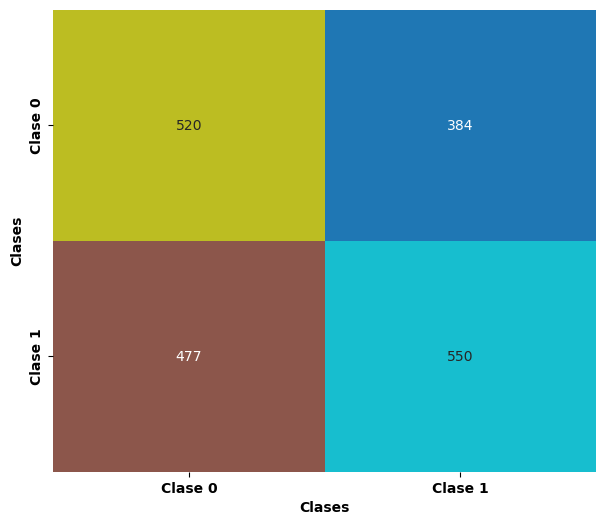

In [87]:
# Clases del problema
classes = ["Clase 0", "Clase 1"]  # Cambiar aquí
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='tab10', cbar=False)
ax.set_xlabel("Clases", weight='bold')
ax.set_ylabel("Clases", weight='bold')
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

In [89]:
# Métricas
print("Precisión:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))
print("F1-Score:", f1_score(y_train, y_train_pred))

Precisión: 0.588865096359743
Recall: 0.5355404089581305
F1-Score: 0.5609382967873534


In [90]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

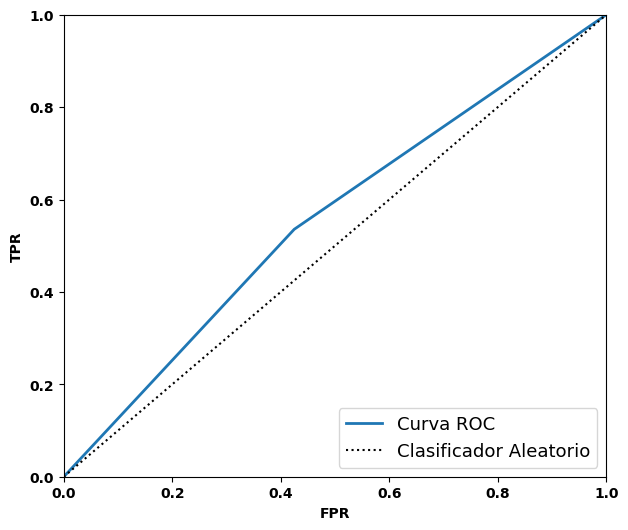

In [91]:
fig, ax = plt.subplots(figsize=(7, 6))
plt.plot(fpr, tpr, linewidth=2, label="Curva ROC")
plt.plot([0, 1], [0, 1], 'k:', label="Clasificador Aleatorio")
ax.set_xlabel('FPR', weight='bold')
ax.set_ylabel('TPR', weight='bold')
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

## Presencia de Hiper-parámetros - RANDOMIZEDSEARCHCV

In [92]:
# Pipeline de preprocesamiento y modelado
sc = StandardScaler()
pca = decomposition.PCA()
log_r = LogisticRegression(random_state=42, solver='liblinear')

In [107]:
# Crea un pipeline de tres pasos. Primero, estandariza los datos.
# Segundo, transforma los datos con PCA.
# Tercero, entrena una regresión logística en los datos.
pipe = Pipeline(steps=[('sc', sc),
                       ('pca', pca),
                       ('logR', log_r)])

In [108]:
# Malla de hiperparámetros
n_components = list(range(1, X.shape[1] + 1))
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

parameters = dict(pca__n_components=n_components,
                  logR__C=C,
                  logR__penalty=penalty)

In [157]:
# Búsqueda aleatoria de hiperparámetros
clf_random = RandomizedSearchCV(pipe, parameters, n_jobs=-1)
clf_random.fit(X_train, y_train)

print('Mejor Penalty:', clf_random.best_estimator_.get_params()['logR__penalty'])
print('Mejor C:', clf_random.best_estimator_.get_params()['logR__C'])
print('Mejor Número de Componentes:', clf_random.best_estimator_.get_params()['pca__n_components'])

Mejor Penalty: l2
Mejor C: 24.420530945486497
Mejor Número de Componentes: 18


In [160]:
# Reporte de resultados
cv_report = pd.DataFrame(clf_random.cv_results_)
cv_report.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_report = cv_report[['param_logR__C', 'param_logR__penalty', 'param_pca__n_components',
                       'split0_test_score', 'split1_test_score', 'split2_test_score',
                       'split3_test_score', 'split4_test_score', 'mean_test_score',
                       'std_test_score']]

cv_report.columns = ['C', 'penalty', 'n_componentes', "split0", "split1", "split2",
                     "split3", "split4", "µ", "σ"]

aciertos = ["split0", "split1", "split2", "split3", "split4", "µ", "σ"]
cv_report[aciertos] = cv_report[aciertos] * 100

print("\nResultados:")
print(cv_report.head())


Resultados:
             C penalty  n_componentes     split0     split1     split2  \
1    24.420531      l2             18  68.992248  57.253886  47.150259   
4  6866.488450      l1             21  69.250646  57.772021  46.891192   
9     0.390694      l1             11  66.925065  58.549223  50.777202   
2  1048.113134      l1             22  68.733850  57.772021  42.487047   
8   159.985872      l2             25  63.824289  58.290155  42.746114   

      split3     split4          µ         σ  
1  57.253886  61.398964  58.409849  7.076339  
4  56.994819  60.880829  58.357901  7.193104  
9  55.440415  54.404145  57.219210  5.450885  
2  56.994819  59.326425  57.062832  8.417810  
8  58.031088  59.844560  56.547241  7.204699  


EVALUACIÓN FINAL EN TEST

In [161]:
final_model = clf_random.best_estimator_
final_predictions = final_model.predict(X_test)

final_acc = accuracy_score(y_test, final_predictions)
final_preci = precision_score(y_test, final_predictions)
final_recall = recall_score(y_test, final_predictions)
final_f1 = f1_score(y_test, final_predictions)

print("\nMétricas en Test:")
print("Acierto =", final_acc * 100)
print("Precisión =", final_preci * 100)
print("Recall =", final_recall * 100)
print("F1 Score =", final_f1 * 100)


Métricas en Test:
Acierto = 67.38882554161916
Precisión = 65.75091575091575
Recall = 78.38427947598254
F1 Score = 71.51394422310757


In [162]:
# Curva ROC final
fpr, tpr, thresholds = roc_curve(y_test, final_predictions)

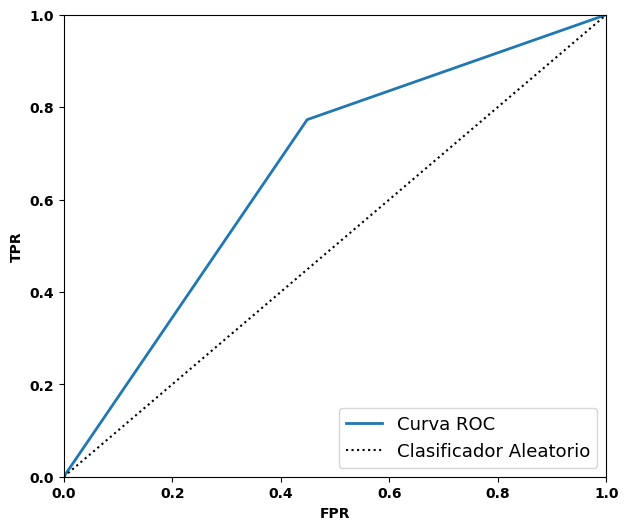

In [104]:
fig, ax = plt.subplots(figsize=(7, 6))
plt.plot(fpr, tpr, linewidth=2, label="Curva ROC")
plt.plot([0, 1], [0, 1], 'k:', label="Clasificador Aleatorio")
ax.set_xlabel('FPR', weight='bold')
ax.set_ylabel('TPR', weight='bold')
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

In [163]:
# Matriz de confusión final
cm = confusion_matrix(y_test, final_predictions)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

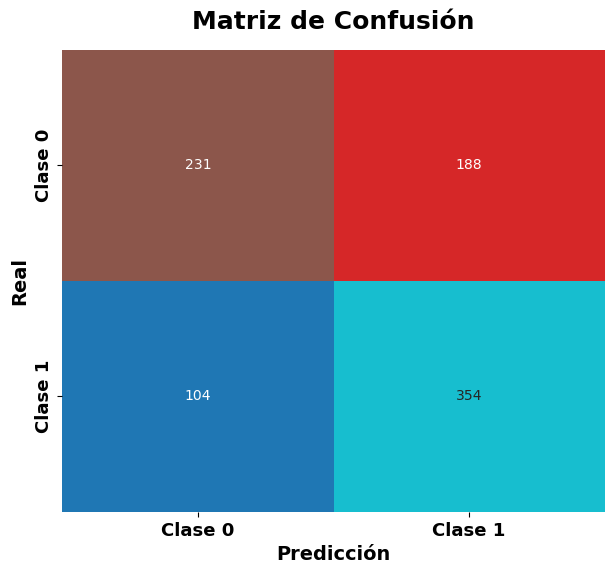

In [106]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='tab10', cbar=False)
ax.set_title("Matriz de Confusión", fontsize=18, weight='bold', pad=15)
ax.set_xlabel("Predicción", weight='bold', fontsize=14)
ax.set_ylabel("Real", weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=13)
plt.yticks(weight='bold', fontsize=13)
plt.show()

## PCA por fuera de pipeline 

PCA – Análisis de Componentes Principales (PCA básico) El análisis de componentes principales es el método principal usado para la reducción lineal de dimensiones. Realiza un mapeo lineal de los datos a un espacio de menor dimensión de tal manera que la varianza de los datos en la representación reducida sea máxima. Con una varianza máxima, se preserva la mayor cantidad posible de información. En otras palabras, selecciona el o los hiperplanos que minimizan la distancia cuadrática media entre el conjunto de datos original y su proyección sobre ese o esos hiperplanos. El primer componente principal explica la mayor varianza en los datos, y así sucesivamente… Todos los componentes en el espacio de menor dimensión son linealmente no correlacionados. Cada una de las nuevas características o componentes creados después del PCA es independiente de los demás.

Con 18 componentes como dio RANDOMIZEDSEARCHCV

In [ ]:
# Aplicar PCA con 18 componentes
X_scaled = estandarizar_datos(X)
pca_18 = aplicar_pca(X_scaled, n_componentes=18)

Varianza explicada por cada componente:
PC1: 0.5791 (57.9%)
PC2: 0.1805 (18.1%)
PC3: 0.0771 (7.7%)
PC4: 0.0543 (5.4%)
PC5: 0.0388 (3.9%)
PC6: 0.0211 (2.1%)
PC7: 0.0117 (1.2%)
PC8: 0.0115 (1.2%)
PC9: 0.0082 (0.8%)
PC10: 0.0051 (0.5%)
PC11: 0.0030 (0.3%)
PC12: 0.0024 (0.2%)
PC13: 0.0019 (0.2%)
PC14: 0.0011 (0.1%)
PC15: 0.0009 (0.1%)
PC16: 0.0007 (0.1%)
PC17: 0.0006 (0.1%)
PC18: 0.0005 (0.1%)

Varianza acumulada total: 0.9985 (99.9%)


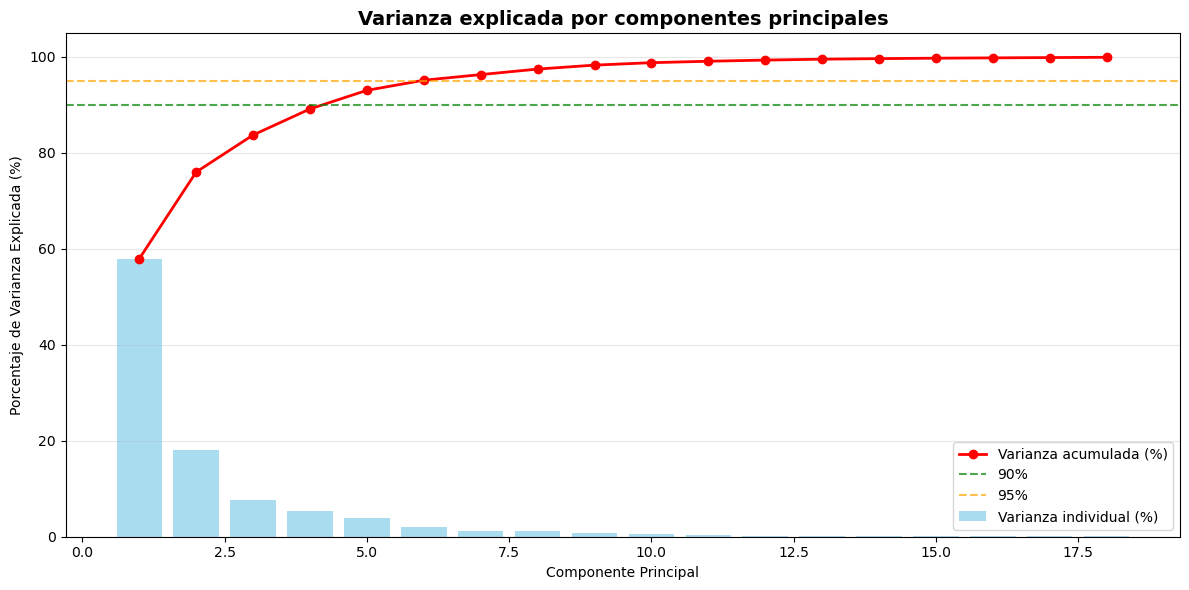

In [165]:
graficar_varianza_pca(pca_18)

In [168]:
# Obtener las loadings de todas las 18 componentes
loadings_df = obtener_loadings(pca_18, features_finales)
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
Termica_global_tallos_FOS_Entropy,-0.041669,0.406129,-0.240287,-0.156871,0.157471,0.249430,0.002120,-0.169034,0.166111,-0.133489,-0.134046,0.028629,0.065310,-0.203685,-0.554663,0.245670,0.060621,-0.273011
Termica_global_tallos_FOS_MaximalGrayLevel,0.251283,0.068644,-0.003285,0.012554,0.173541,0.085358,0.002077,-0.015993,0.008521,0.071565,-0.331151,0.464140,0.135119,-0.184784,-0.214666,-0.336408,-0.256769,0.481148
Termica_global_tallos_FOS_Mean,0.261534,0.003417,-0.048355,-0.001787,-0.034828,0.029405,0.012261,0.002663,-0.025128,-0.008809,0.001693,0.083961,-0.196642,0.128408,-0.037400,-0.029435,0.032778,-0.033235
Termica_global_tallos_FOS_Energy,0.044226,-0.392332,0.201109,0.276378,-0.109703,-0.165830,0.014017,0.321057,-0.232140,0.369141,-0.250142,0.047998,0.006933,-0.170732,-0.398187,0.166857,-0.069920,-0.215950
Termica_global_tallos_FOS_MinimalGrayLevel,0.250033,-0.058184,0.104306,-0.104532,-0.022004,-0.143337,-0.028843,0.085378,-0.096167,-0.158384,0.427385,0.191596,0.269985,-0.001838,-0.021863,0.005017,0.003056,-0.097408
Termica_global_hojas_FOS_MinimalGrayLevel,0.251163,-0.050422,0.087885,-0.108137,-0.019791,-0.105603,-0.004502,0.116118,-0.046888,-0.234426,0.386179,0.174394,0.414510,-0.055365,-0.176393,0.193902,0.064707,0.078936
Termica_global_hojas_FOS_MaximalGrayLevel,0.249362,0.085301,-0.003125,0.060105,0.153049,0.026032,0.097669,-0.037803,0.124120,0.150168,-0.339348,0.296050,0.334212,-0.064098,0.569580,0.161389,0.108095,-0.395006
Termica_global_hojas_FOS_75Percentile,0.255494,0.067508,-0.068810,0.036409,-0.042730,-0.039783,-0.092392,-0.015924,0.079578,0.139355,-0.023709,-0.323973,0.158039,0.104548,0.019059,0.141972,-0.023420,0.347267
Termica_global_hojas_FOS_CoefficientOfVariation,-0.258899,-0.008064,0.055018,0.011782,0.019332,0.000430,0.009661,-0.027584,-0.020932,-0.039167,-0.000721,0.445140,-0.170914,0.232631,0.101666,0.506341,-0.047240,0.340909
Termica_global_tallos_FOS_HistogramWidth,-0.067835,0.354117,-0.269754,-0.080642,0.156904,0.077952,-0.010435,0.799922,-0.158419,0.088769,0.068368,-0.010722,-0.061984,-0.003689,0.112455,0.021368,-0.028340,0.024334


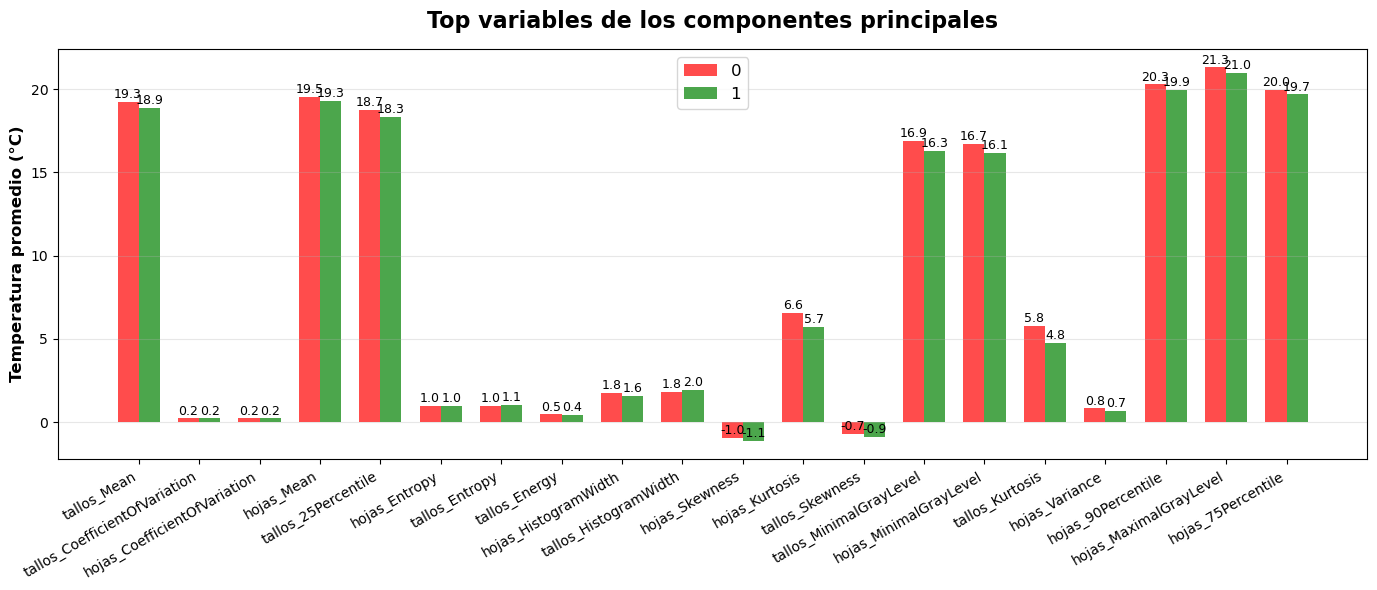

In [167]:
graficar_top_variables(loadings_df, data, target='target', num_pc=4, top_n=5)